## Weather Analysis
In this section, we will perform a detailed analysis of weather data across various major U.S. cities. Our goal is to understand trends and patterns in average temperatures (TAVG) over time and how they correlate with urban population growth. We will utilize linear regression and SARIMA time series analysis to forecast future temperatures and understand seasonal patterns.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# List of city names and states
cities = ['New York', 'Jacksonville', 'Dallas', 'San Antonio', 'San Diego', 'Houston', 'Phoenix', 'Philadelphia', 'Los Angeles', 'Seattle']
states = ['NY', 'FL', 'TX', 'TX', 'CA', 'TX', 'AZ', 'PA', 'CA', 'WA']

In [4]:
# Load the population data
pop = pd.read_csv('/Users/rileychisholm/Downloads/population_data.csv')

In [6]:
# Load the combined weather dataset
combined_df = pd.read_csv('/Users/rileychisholm/Downloads/Combined_Weather_Data.csv')

In [7]:
# Convert DATE to datetime format
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])

In [8]:
# Add a month column for later use
combined_df['month'] = combined_df['DATE'].dt.month

In [12]:
# Function to get data sorted by city
def get_city_data(df, city_name):
    return df[df['City'] == city_name]

### Exploratory Data Analysis (EDA)
In this step, we'll perform some initial exploratory data analysis to get a sense of the trends in temperature over time. We'll also visualize the distribution of average temperatures (TAVG) by month to identify any seasonal patterns.


In [32]:
# Group by 'Year' and calculate the average 'TAVG' for each year
avg_tavg_per_year = combined_df.groupby('Year')['TAVG'].mean().reset_index()

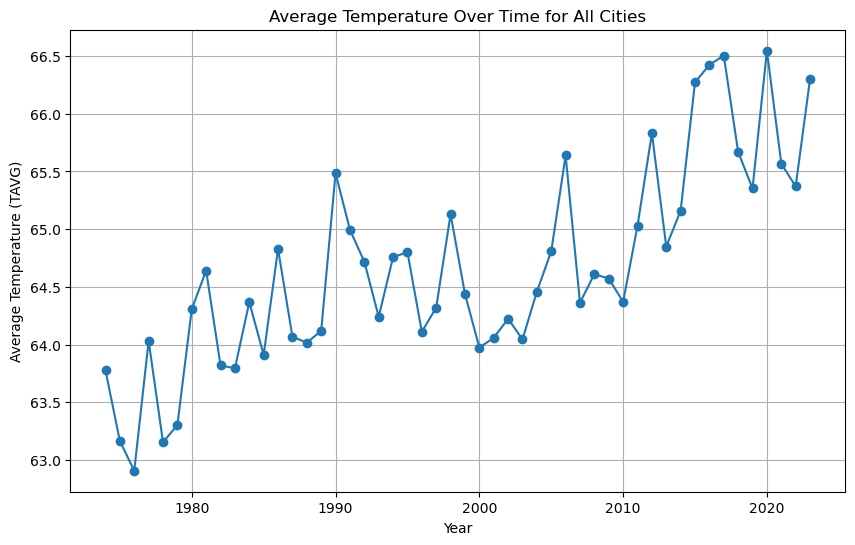

In [33]:
# Plot the average 'TAVG' over time
plt.figure(figsize=(10, 6))
plt.plot(avg_tavg_per_year['Year'], avg_tavg_per_year['TAVG'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Temperature (TAVG)')
plt.title('Average Temperature Over Time for All Cities')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

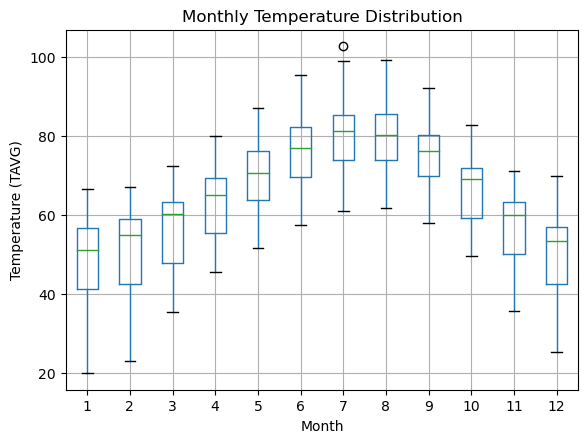

In [15]:
# Box plot of TAVG by month
plt.figure(figsize=(10, 6))
combined_df.boxplot(column='TAVG', by='month')
plt.xlabel('Month')
plt.ylabel('Temperature (TAVG)')
plt.title('Monthly Temperature Distribution')
plt.suptitle('')
plt.show()

### Linear Regression Analysis
To understand how urban population growth impacts temperature, we perform linear regression analysis for each city. We aim to predict the average temperature based on the urban population of the city.


In [22]:
# Function to perform linear regression analysis for one city
def linear_regression_city(city_name):
    # Filter the dataset for the specified city
    city_weather_df = combined_df[combined_df['City'] == city_name]

    # Aggregate monthly data to yearly data by calculating the average temperature (TAVG) for each year
    yearly_avg_temp = city_weather_df.groupby('Year')['TAVG'].mean().reset_index()

    # Merge with population data
    city_pop_df = pop[pop['City'] == city_name]
    city_merged_df = pd.merge(yearly_avg_temp, city_pop_df, on='Year', how='left')

    # Drop rows with any missing values after the merge
    city_merged_df.dropna(inplace=True)

    # Define the feature (urban population) and target (average temperature)
    X = city_merged_df[['Population']]
    y = city_merged_df['TAVG']

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'\nAnalysis for {city_name}:\n')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Actual')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
    plt.title(f'Linear Regression: Predicted vs Actual Temperature for {city_name}')
    plt.xlabel('Urban Population')
    plt.ylabel('Temperature (TAVG)')
    plt.legend()
    plt.show()


Analysis for New York:

Mean Squared Error: 1.3026895848732916
R-squared: -0.2978802176224382


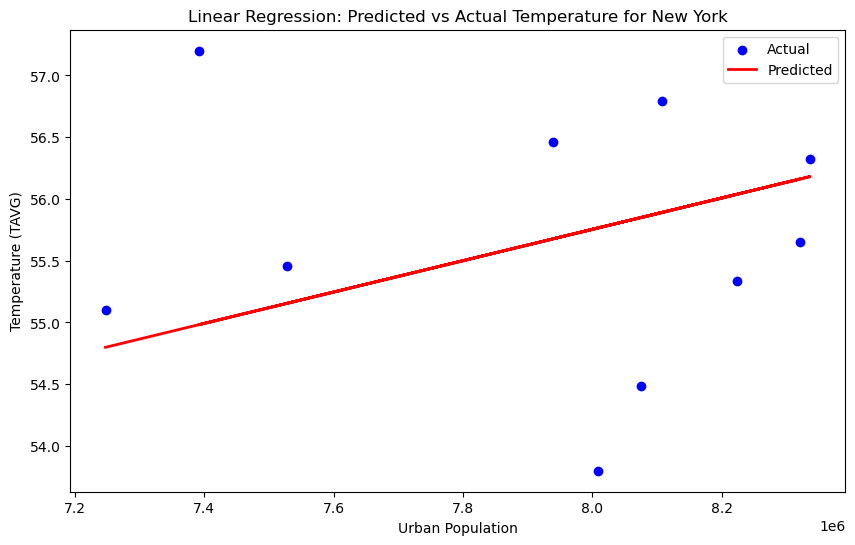


Analysis for Jacksonville:

Mean Squared Error: 0.9190088821268232
R-squared: 0.25624968231608314


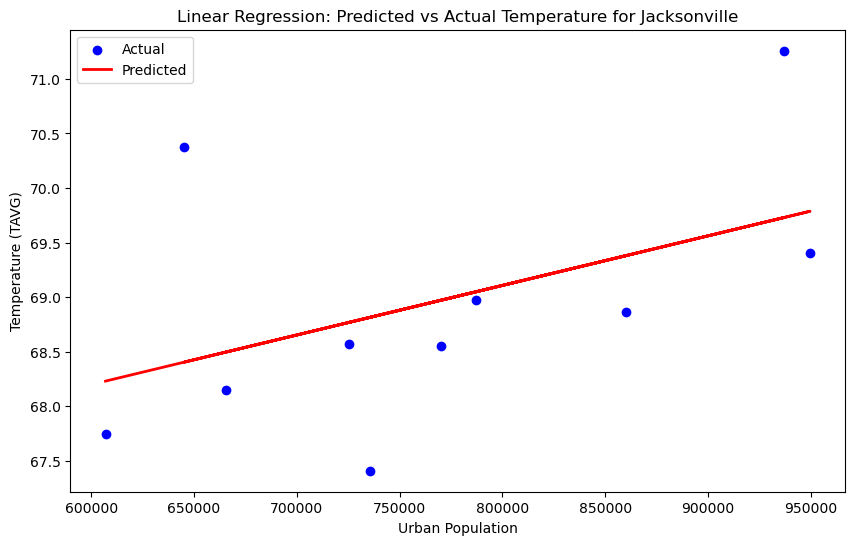


Analysis for Dallas:

Mean Squared Error: 0.8421744818042043
R-squared: 0.23196296025268226


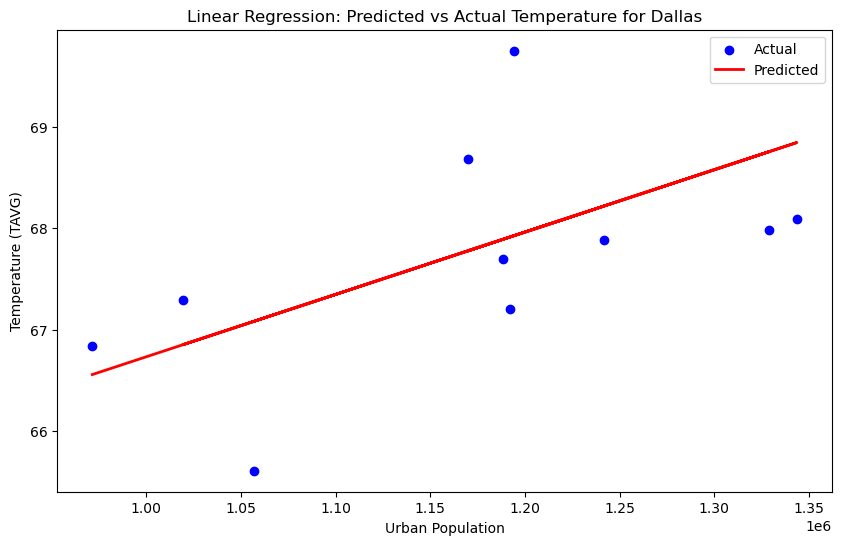


Analysis for San Antonio:

Mean Squared Error: 0.6186622608720995
R-squared: 0.37703277604066243


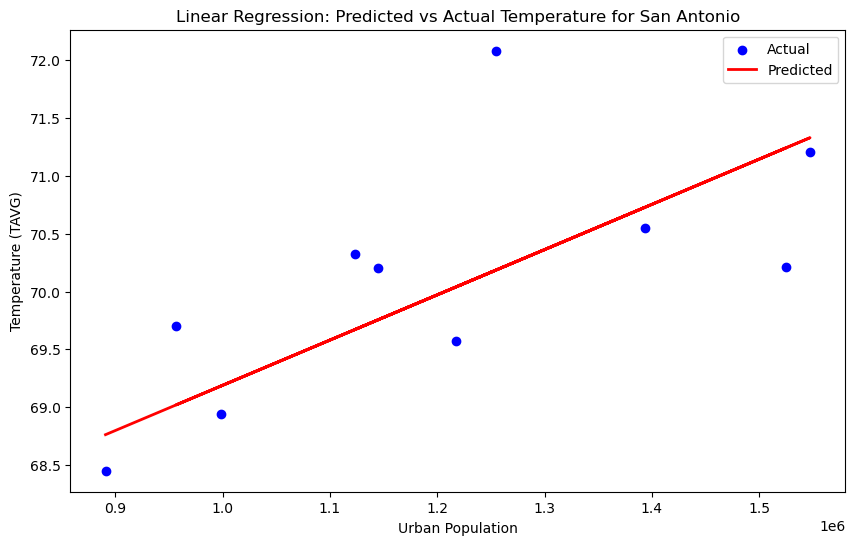


Analysis for San Diego:

Mean Squared Error: 1.411874114583234
R-squared: -1.4420990281324548


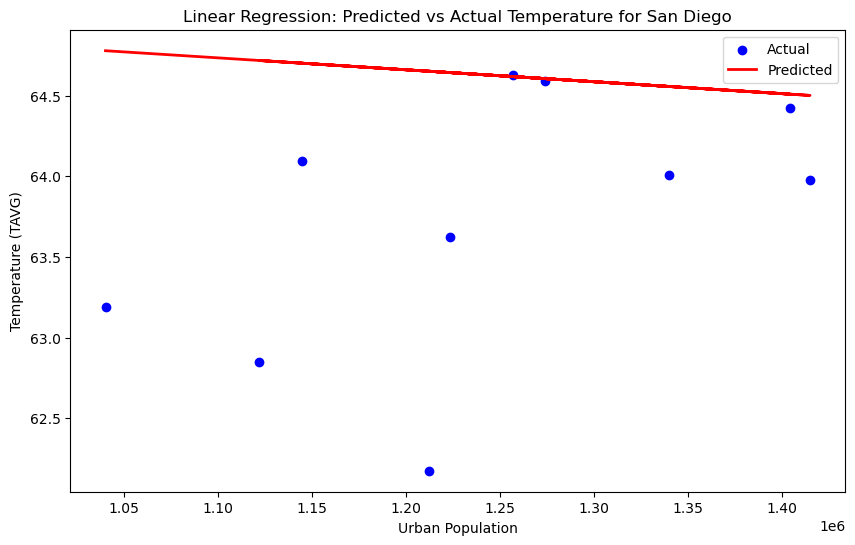


Analysis for Houston:

Mean Squared Error: 0.47945839189343636
R-squared: 0.3540479039197125


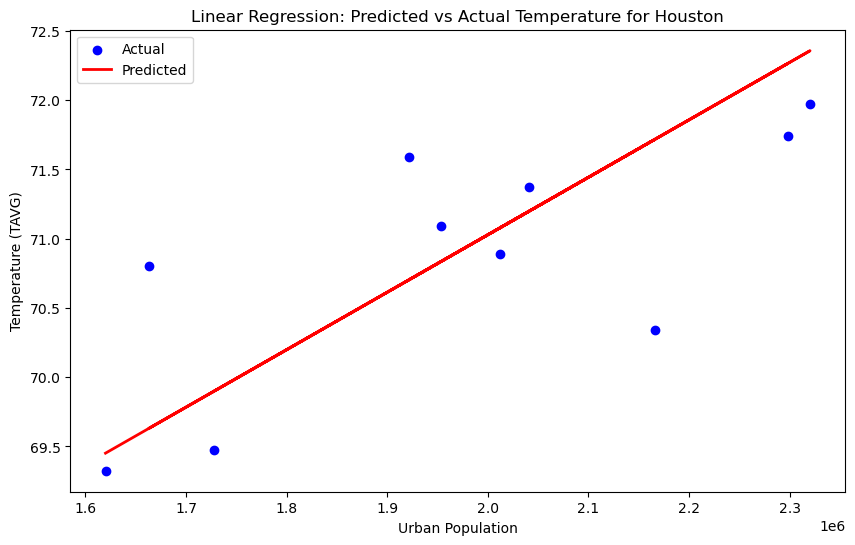


Analysis for Phoenix:

Mean Squared Error: 0.7828815149027768
R-squared: -1.7923418467833714


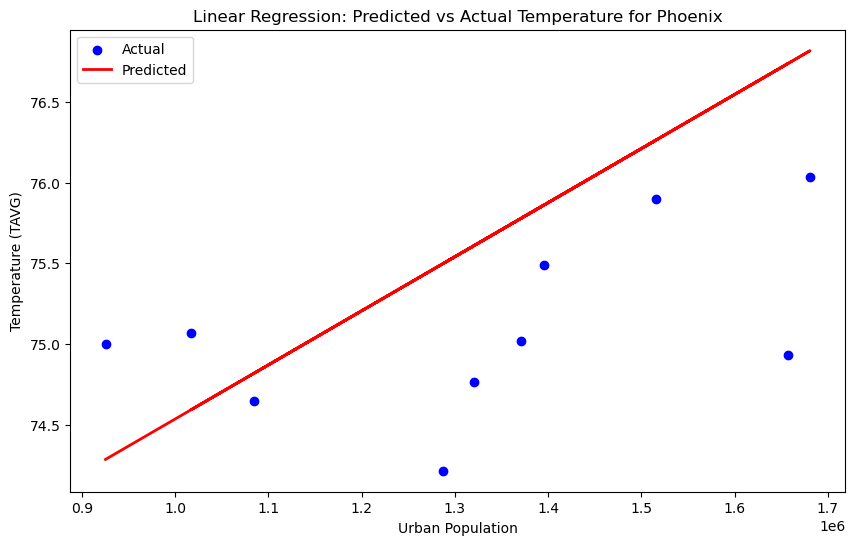


Analysis for Philadelphia:

Mean Squared Error: 1.6347356805474473
R-squared: -0.3268240467621655


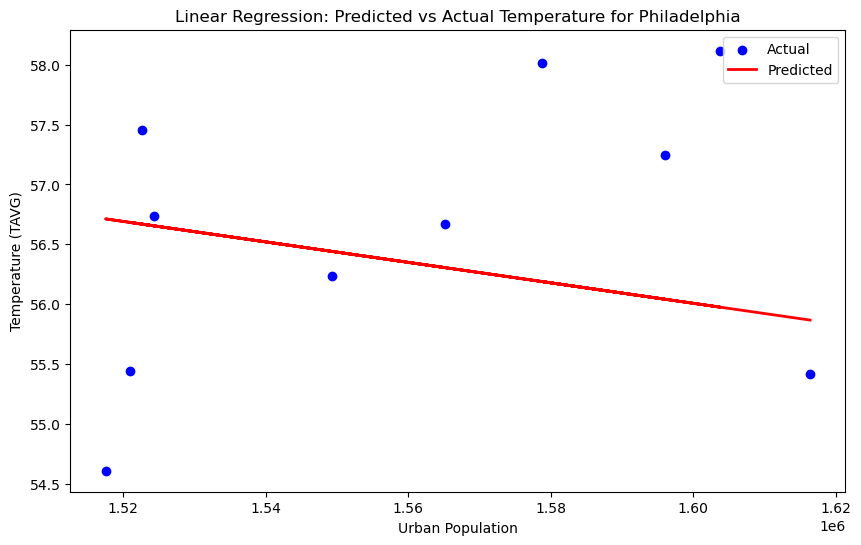


Analysis for Los Angeles:

Mean Squared Error: 1.1564702463027632
R-squared: -0.8682271765480389


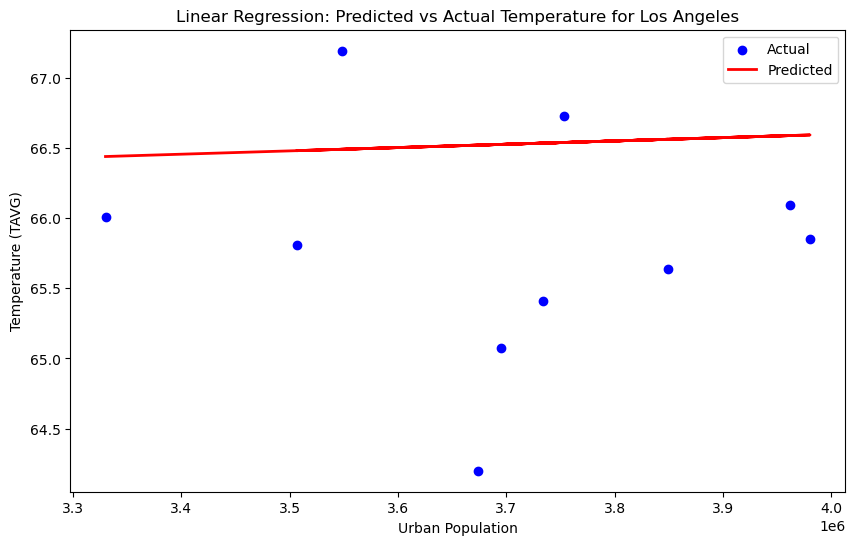


Analysis for Seattle:

Mean Squared Error: 0.7626234511279188
R-squared: -0.02610037489040562


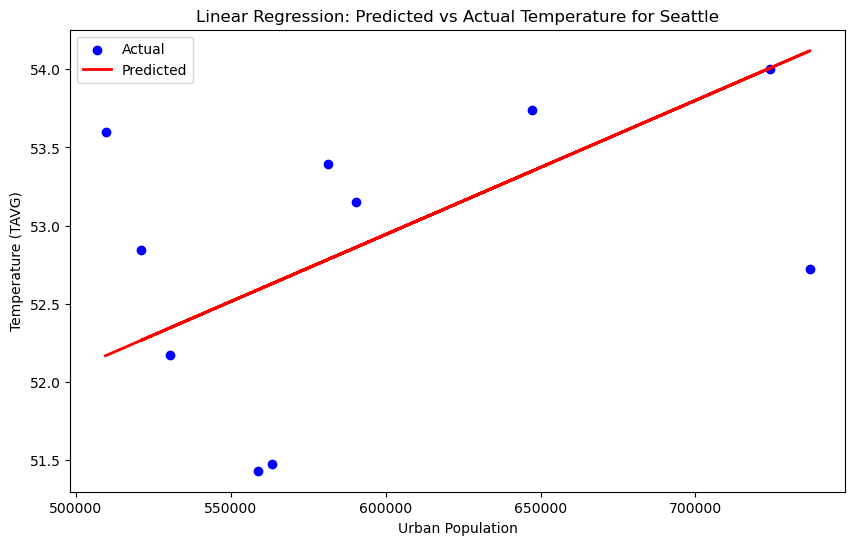

In [23]:
# Perform analysis for each city
for city in cities:
    linear_regression_city(city) 

### SARIMA Time Series Analysis
To further investigate the temperature trends, we perform SARIMA time series analysis. This method allows us to model and forecast temperatures, taking into account seasonal patterns and trends.


In [36]:
# Function to perform SARIMA time series analysis for one city
def sarima_city(city_name, train_ratio=0.8):
    # Filter the dataset for the specified city
    city_weather_df = combined_df[combined_df['City'] == city_name]
    city_weather_df.set_index('DATE', inplace=True)
    
    # Decompose the time series to show trend and seasonality if possible
    if len(city_weather_df) >= 24: 
        decomposition = seasonal_decompose(city_weather_df['TAVG'], model='additive', period=12)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(411)
        plt.plot(city_weather_df['TAVG'], label='Original')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuals')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough data for seasonal decomposition for {city_name}. Required: 24, Available: {len(city_weather_df)}")
    
    # Split the data into training and testing sets
    train_size = int(len(city_weather_df) * train_ratio)
    train, test = city_weather_df[:train_size], city_weather_df[train_size:]
    
    # Fit SARIMA model on training set
    model = sm.tsa.statespace.SARIMAX(train['TAVG'], 
                                      order=(5, 1, 0), 
                                      seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    
    # Forecast the test set
    forecast = results.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Plot the original, forecasted, and test values
    plt.figure(figsize=(10, 6))
    plt.plot(city_weather_df['TAVG'], label='Original')
    plt.plot(results.fittedvalues, color='red', label='Fitted')
    plt.plot(forecast_values, color='green', label='Forecast')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'SARIMA Time Series Analysis for {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (TAVG)')
    plt.legend()
    plt.show()
    
    print(f"SARIMA Model Summary for {city_name}")


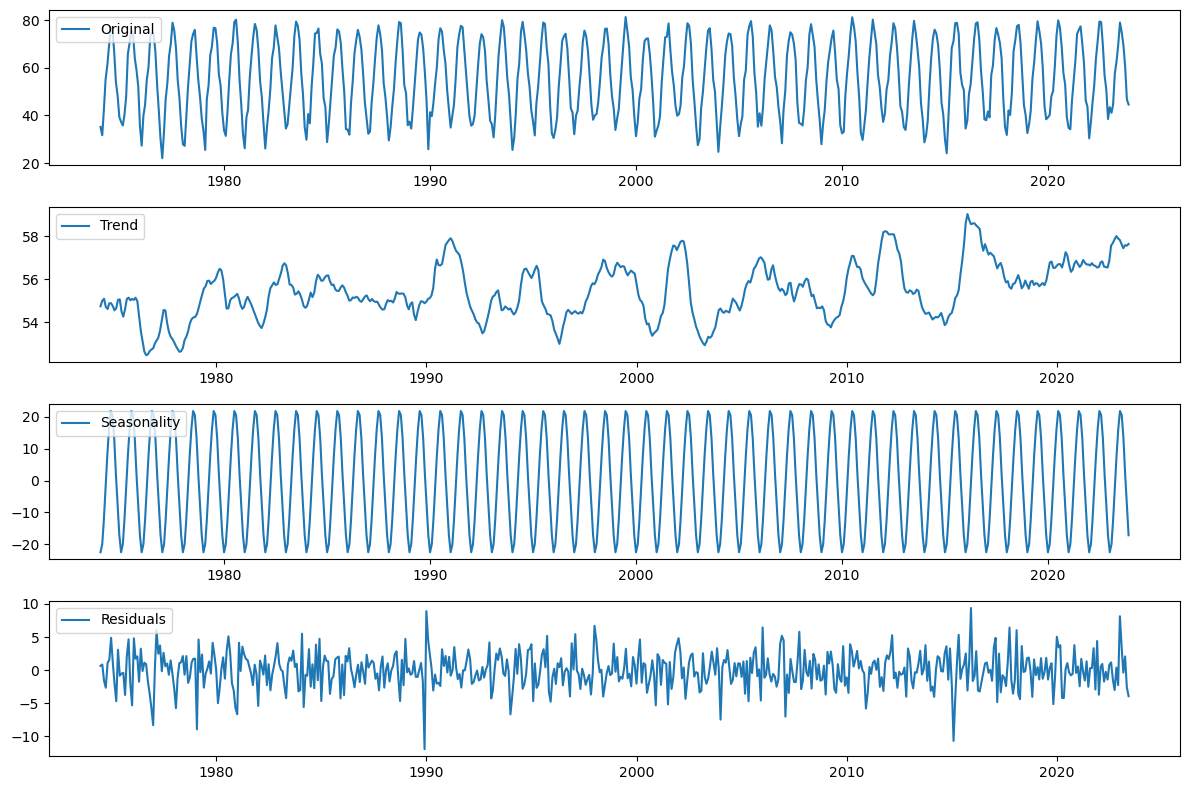

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64303D+00    |proj g|=  8.50502D-02

At iterate    5    f=  2.51636D+00    |proj g|=  1.65434D-02

At iterate   10    f=  2.50711D+00    |proj g|=  5.55745D-03

At iterate   15    f=  2.50593D+00    |proj g|=  1.29504D-03

At iterate   20    f=  2.50576D+00    |proj g|=  1.69160D-03

At iterate   25    f=  2.50573D+00    |proj g|=  3.36250D-04

At iterate   30    f=  2.50572D+00    |proj g|=  2.73037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

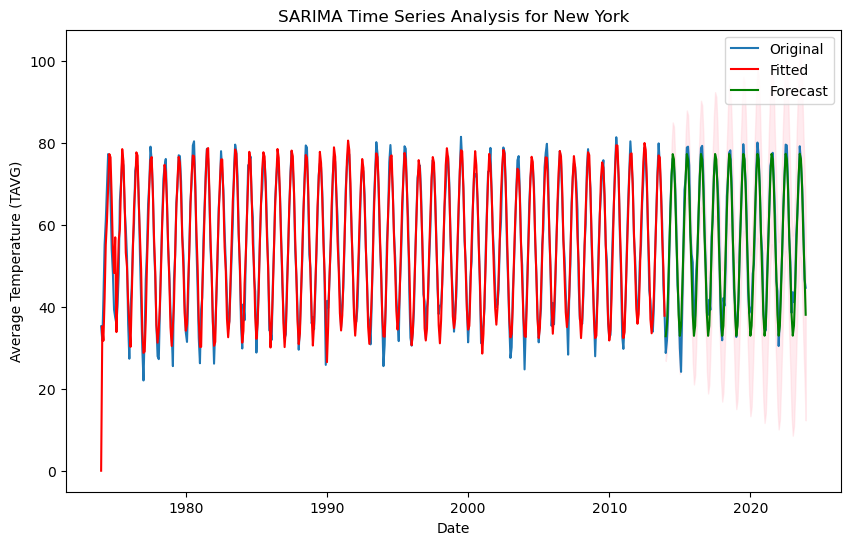

SARIMA Model Summary for New York


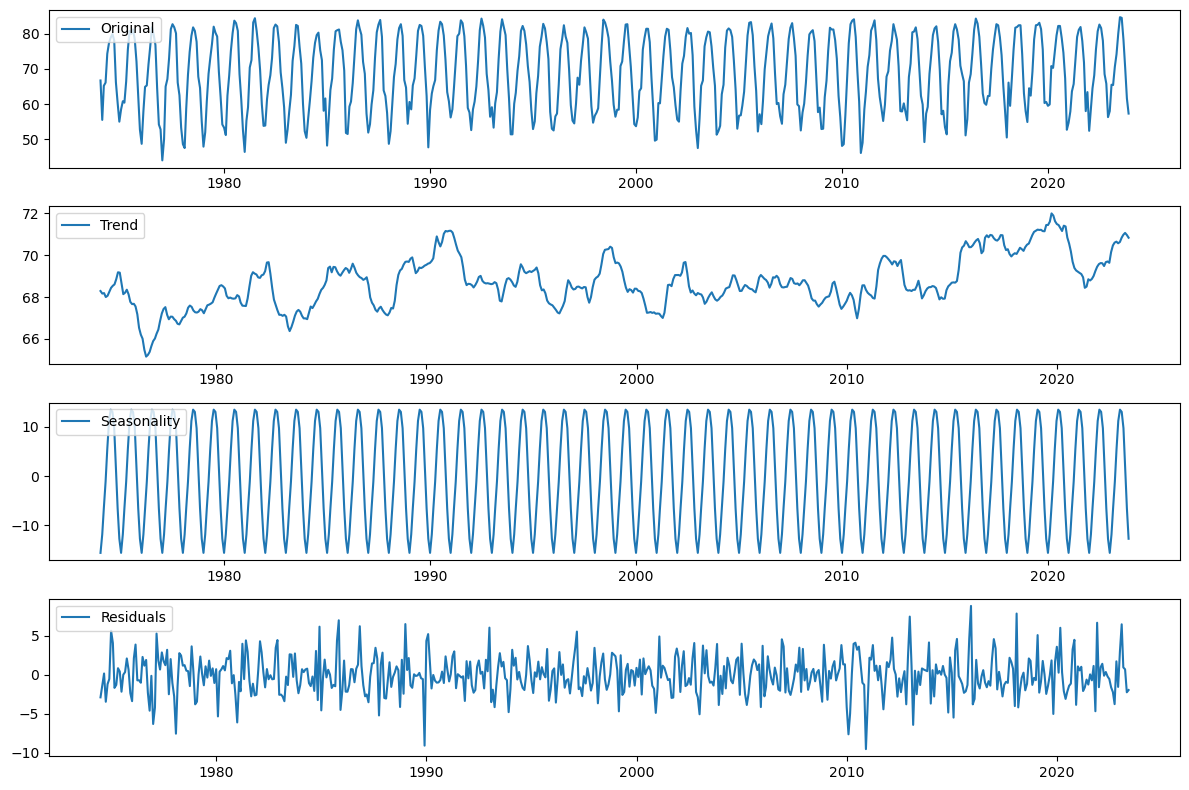

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55041D+00    |proj g|=  7.28784D-02

At iterate    5    f=  2.44888D+00    |proj g|=  2.26580D-02

At iterate   10    f=  2.43589D+00    |proj g|=  6.32612D-03

At iterate   15    f=  2.43452D+00    |proj g|=  1.08331D-03

At iterate   20    f=  2.43431D+00    |proj g|=  2.10503D-03

At iterate   25    f=  2.43428D+00    |proj g|=  1.90756D-04

At iterate   30    f=  2.43428D+00    |proj g|=  2.41012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

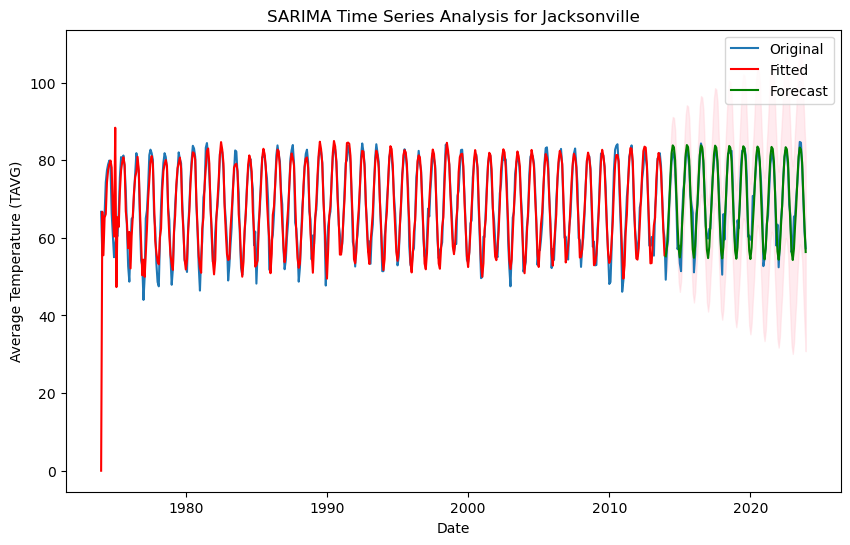

SARIMA Model Summary for Jacksonville


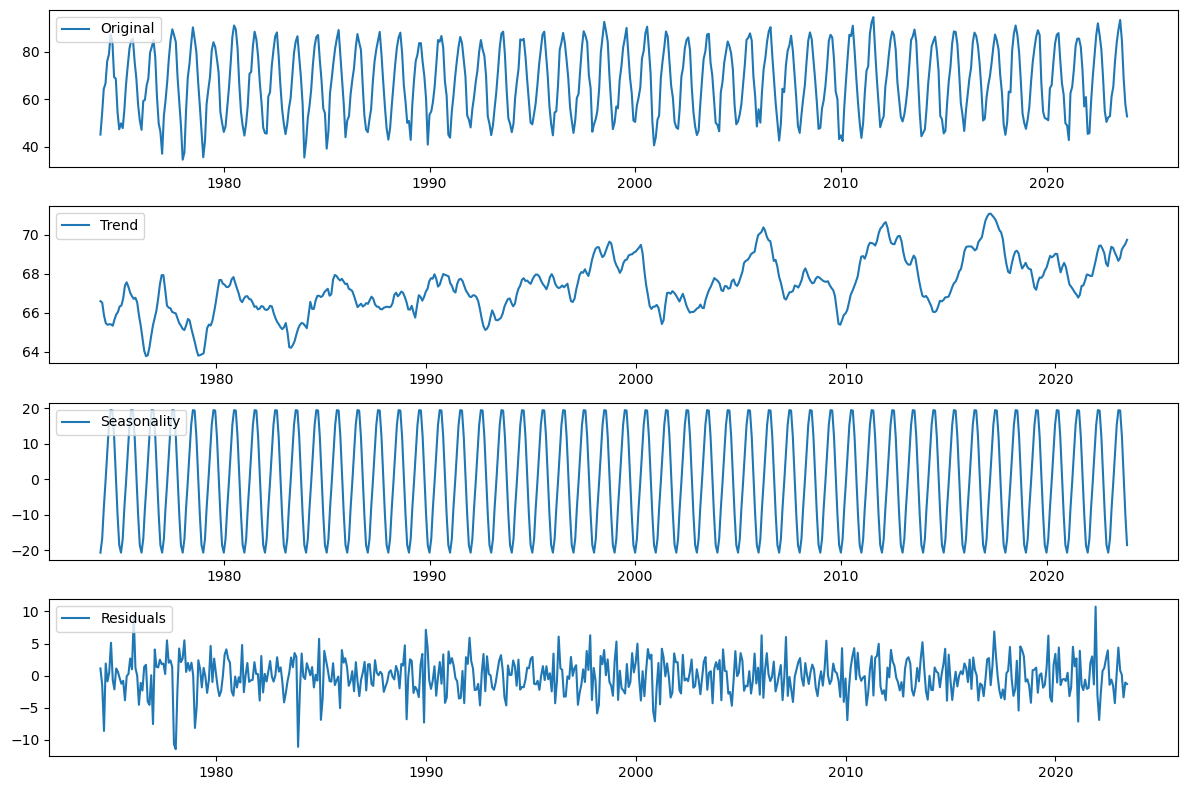

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67577D+00    |proj g|=  7.75953D-02

At iterate    5    f=  2.56690D+00    |proj g|=  1.82942D-02

At iterate   10    f=  2.55797D+00    |proj g|=  4.66838D-03

At iterate   15    f=  2.55733D+00    |proj g|=  4.08870D-03

At iterate   20    f=  2.55724D+00    |proj g|=  8.27497D-04

At iterate   25    f=  2.55723D+00    |proj g|=  2.78447D-04

At iterate   30    f=  2.55722D+00    |proj g|=  6.60308D-05

At iterate   35    f=  2.55722D+00    |proj g|=  1.21285D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

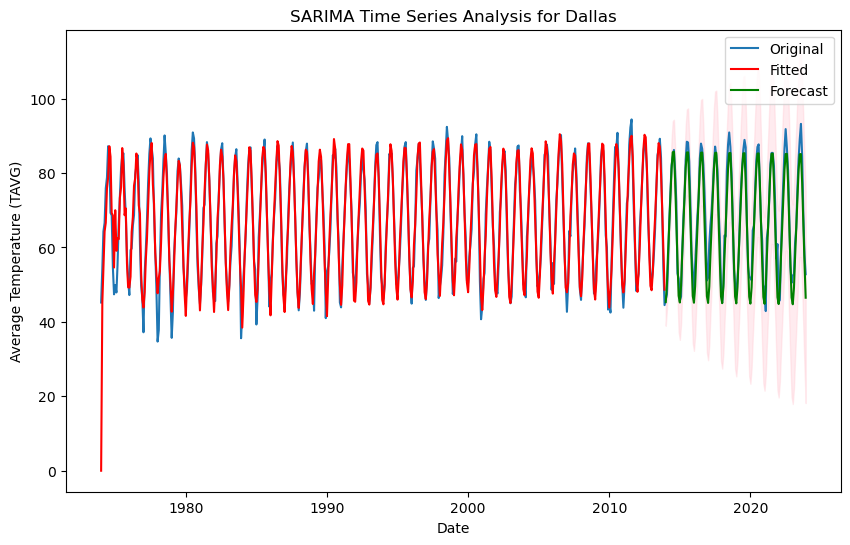

SARIMA Model Summary for Dallas


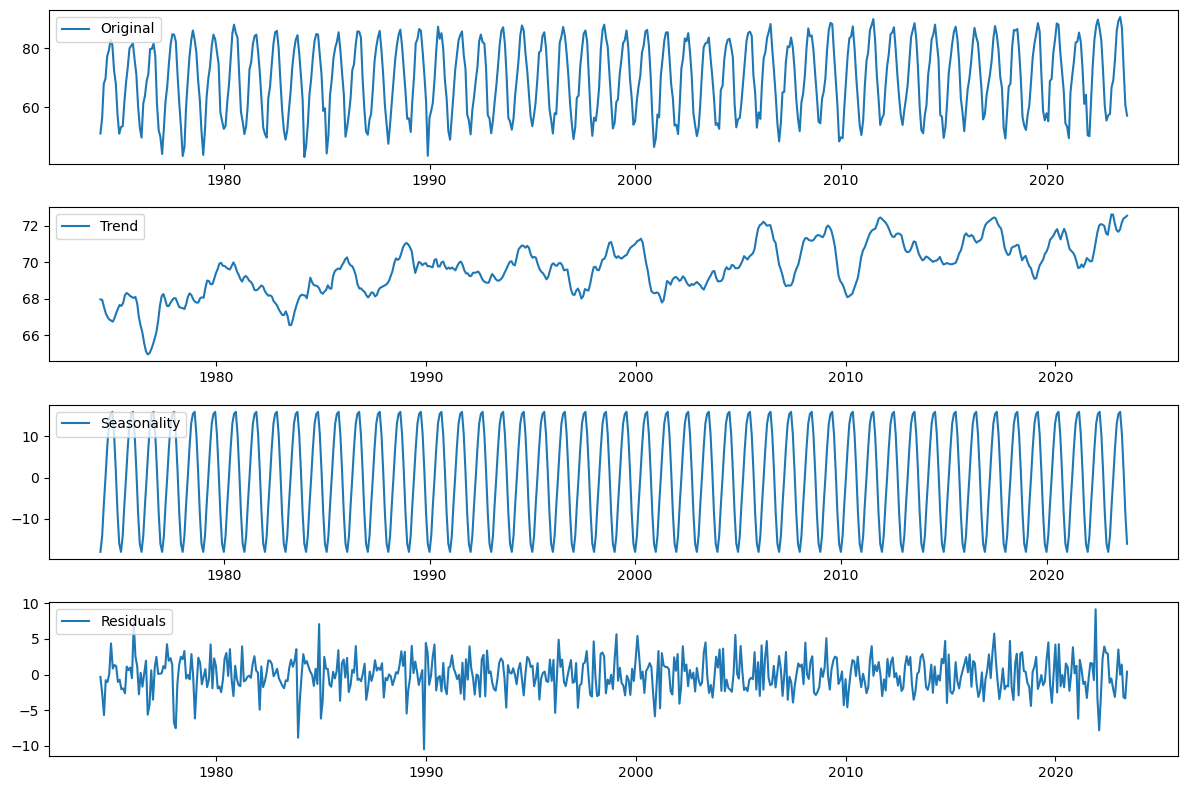

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52299D+00    |proj g|=  8.51601D-02

At iterate    5    f=  2.40952D+00    |proj g|=  2.67074D-02

At iterate   10    f=  2.39665D+00    |proj g|=  2.65841D-03

At iterate   15    f=  2.39593D+00    |proj g|=  3.13674D-03

At iterate   20    f=  2.39589D+00    |proj g|=  5.04498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   2.175D-05   2.396D+00
  F =   2.3958895940528828     

CONVERG

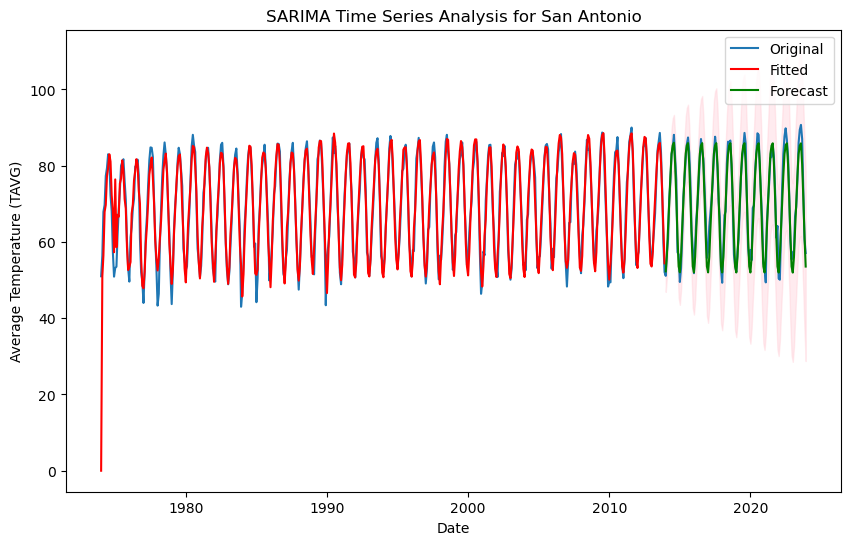

SARIMA Model Summary for San Antonio


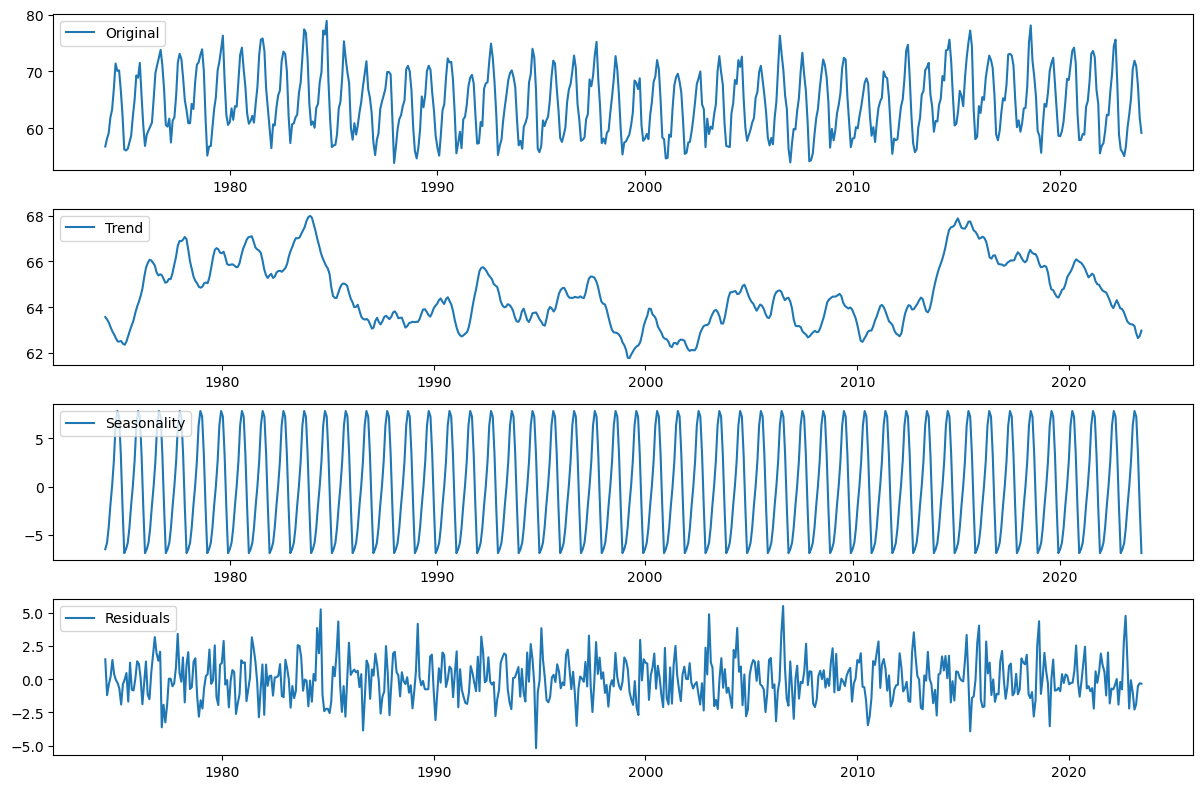

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07374D+00    |proj g|=  1.57389D-01

At iterate    5    f=  1.96830D+00    |proj g|=  3.40310D-02

At iterate   10    f=  1.95128D+00    |proj g|=  5.79480D-03

At iterate   15    f=  1.95058D+00    |proj g|=  5.27122D-03

At iterate   20    f=  1.95050D+00    |proj g|=  4.80662D-04

At iterate   25    f=  1.95049D+00    |proj g|=  1.36169D-04

At iterate   30    f=  1.95049D+00    |proj g|=  7.45352D-05

At iterate   35    f=  1.95049D+00    |proj g|=  1.48222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

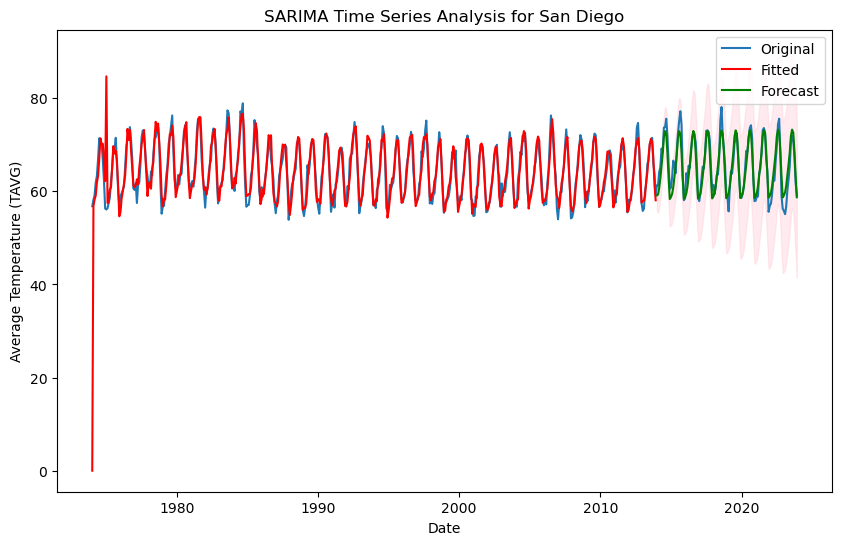

SARIMA Model Summary for San Diego


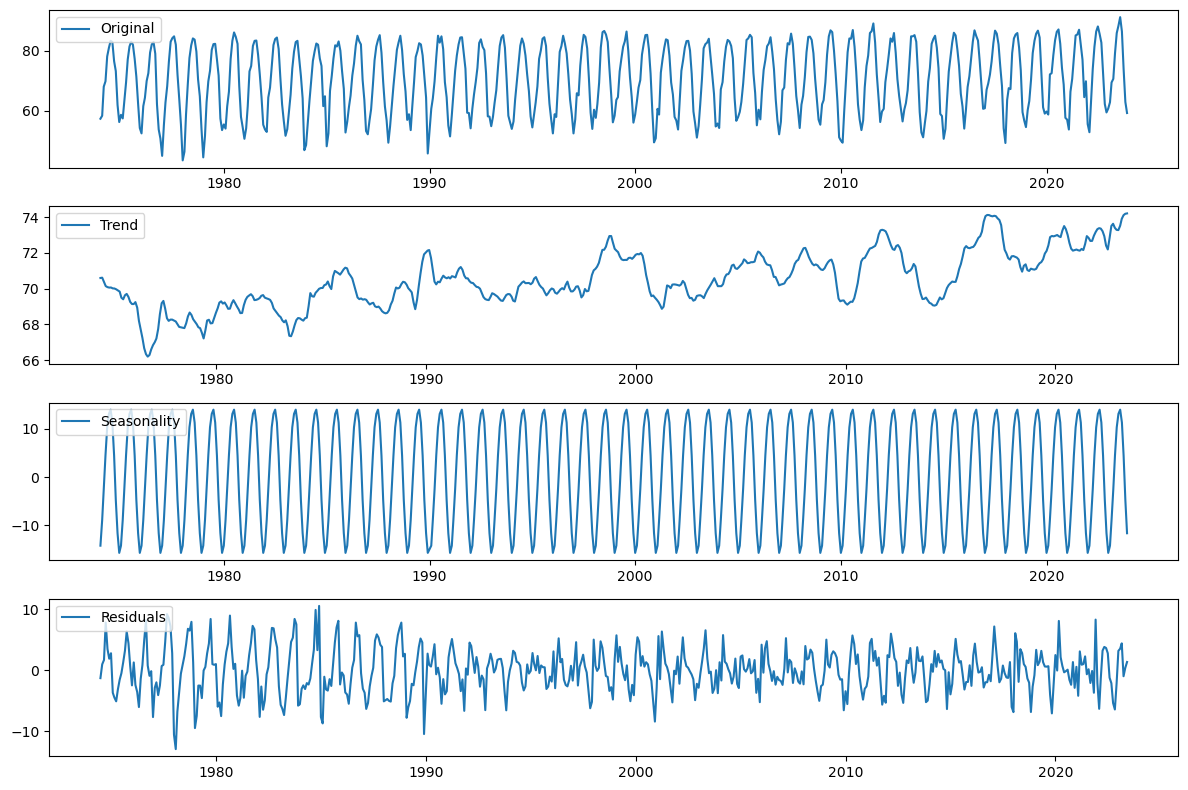

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56888D+00    |proj g|=  1.29325D-01

At iterate    5    f=  2.50287D+00    |proj g|=  2.91087D-02

At iterate   10    f=  2.50219D+00    |proj g|=  6.27023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     12     16      1     0     0   9.811D-06   2.502D+00
  F =   2.5021880556820304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


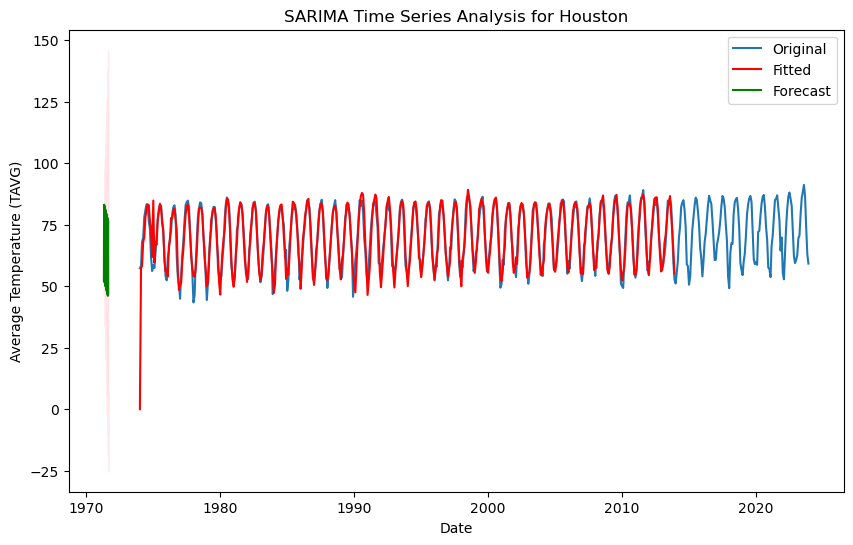

SARIMA Model Summary for Houston


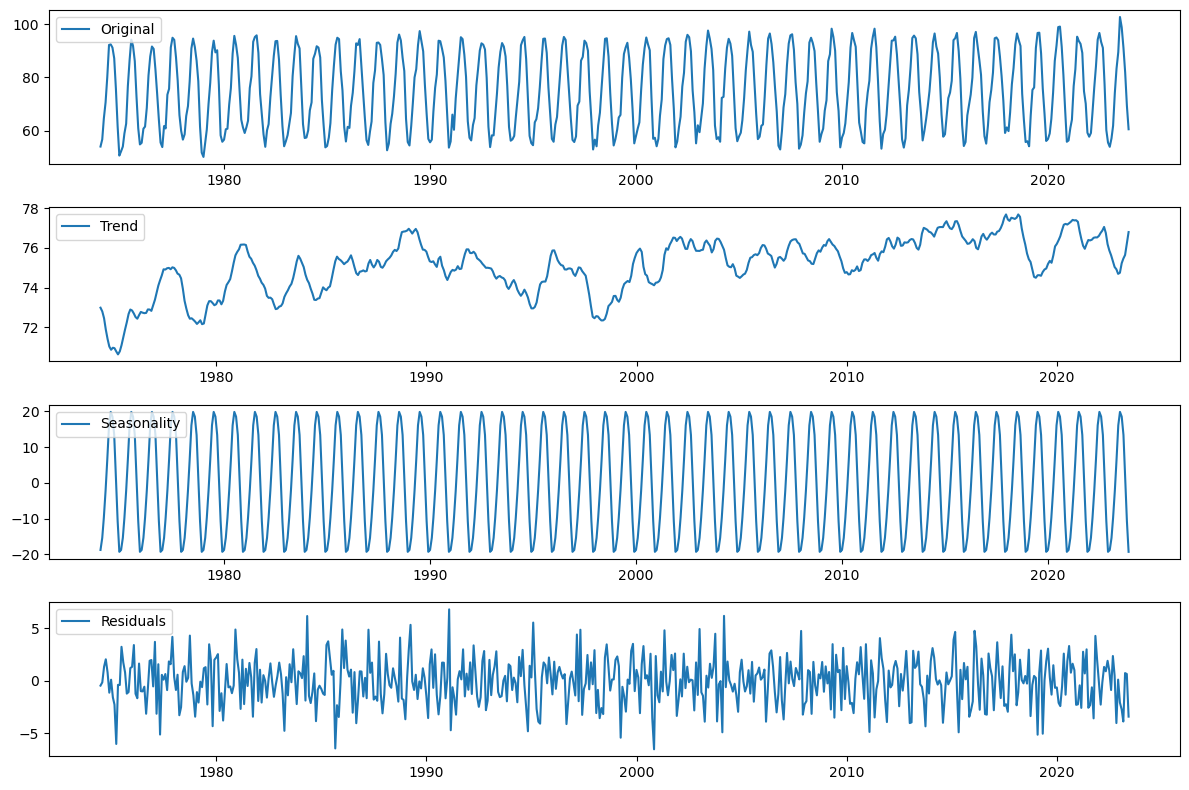

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44632D+00    |proj g|=  9.14378D-02

At iterate    5    f=  2.33933D+00    |proj g|=  5.00241D-02

At iterate   10    f=  2.32851D+00    |proj g|=  4.05301D-03

At iterate   15    f=  2.32795D+00    |proj g|=  1.05234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     21      1     0     0   8.215D-06   2.328D+00
  F =   2.3279527637805537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


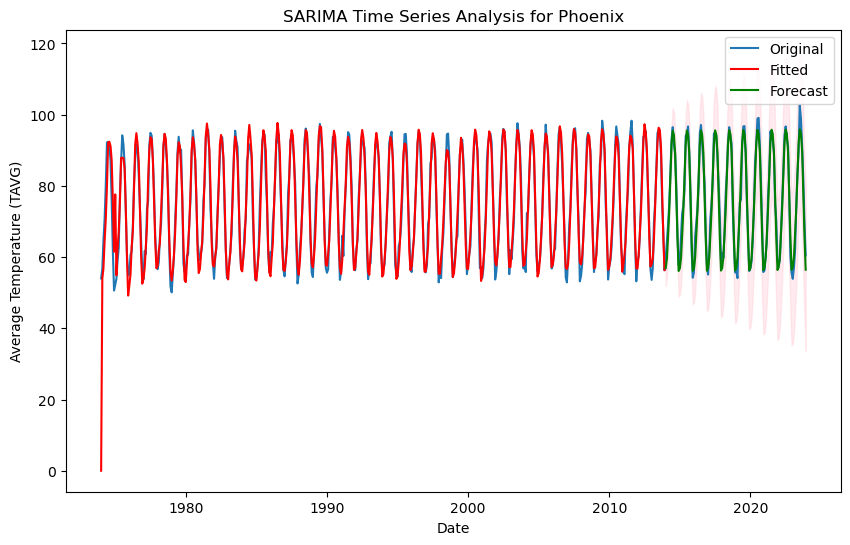

SARIMA Model Summary for Phoenix


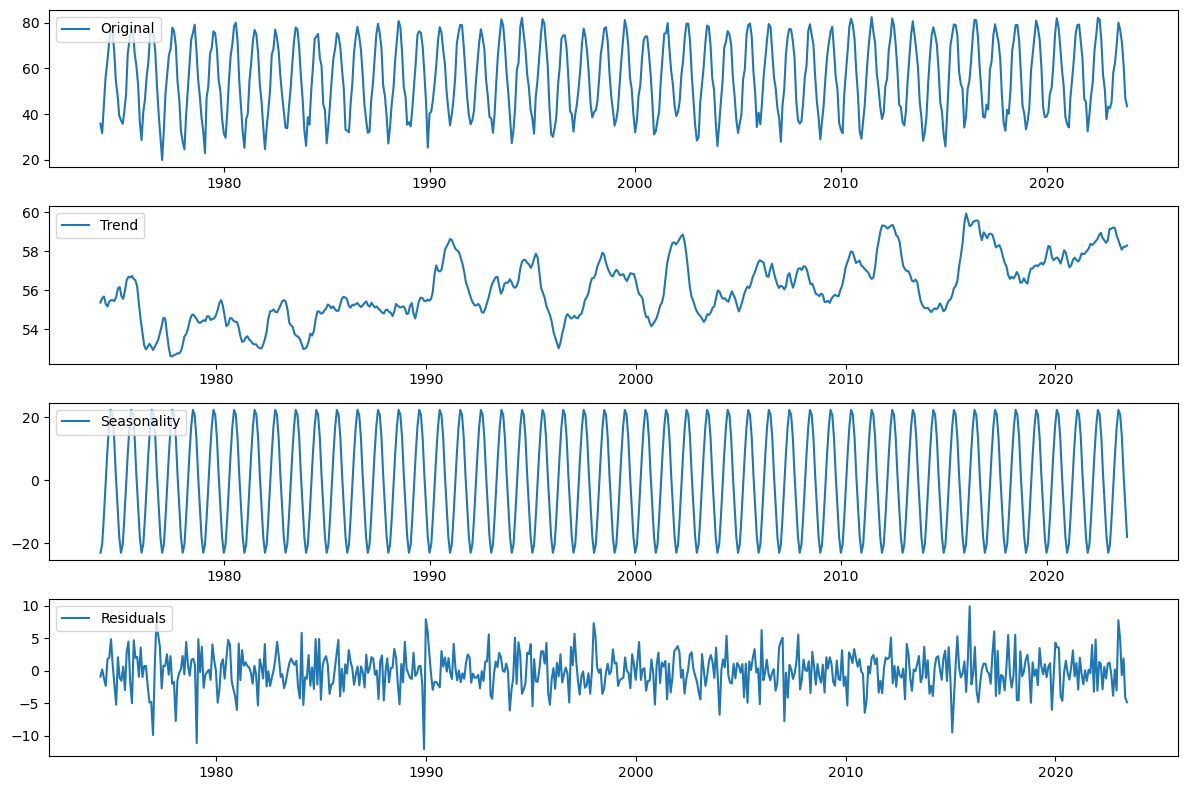

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68345D+00    |proj g|=  7.84162D-02

At iterate    5    f=  2.55683D+00    |proj g|=  1.70179D-02

At iterate   10    f=  2.54742D+00    |proj g|=  9.50436D-03

At iterate   15    f=  2.54640D+00    |proj g|=  3.64553D-03

At iterate   20    f=  2.54631D+00    |proj g|=  3.81847D-04

At iterate   25    f=  2.54631D+00    |proj g|=  1.89187D-04

At iterate   30    f=  2.54631D+00    |proj g|=  4.36593D-05

At iterate   35    f=  2.54631D+00    |proj g|=  1.51274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

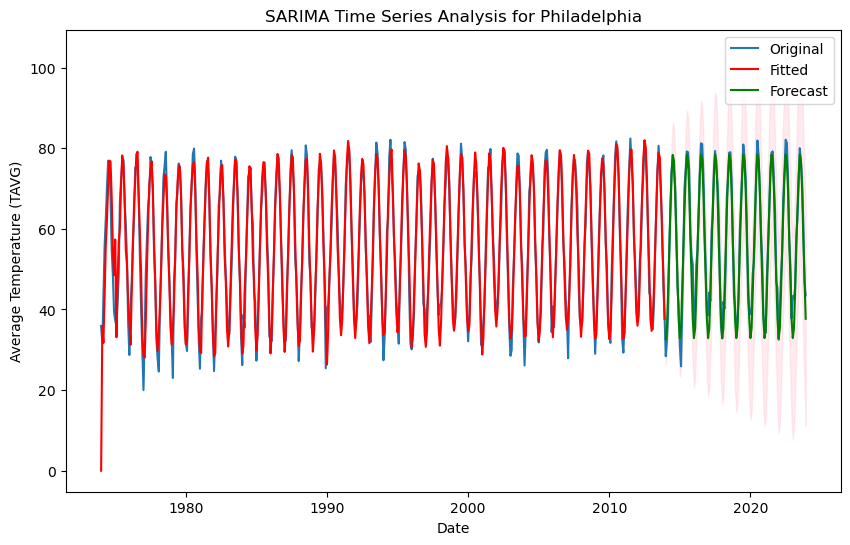

SARIMA Model Summary for Philadelphia


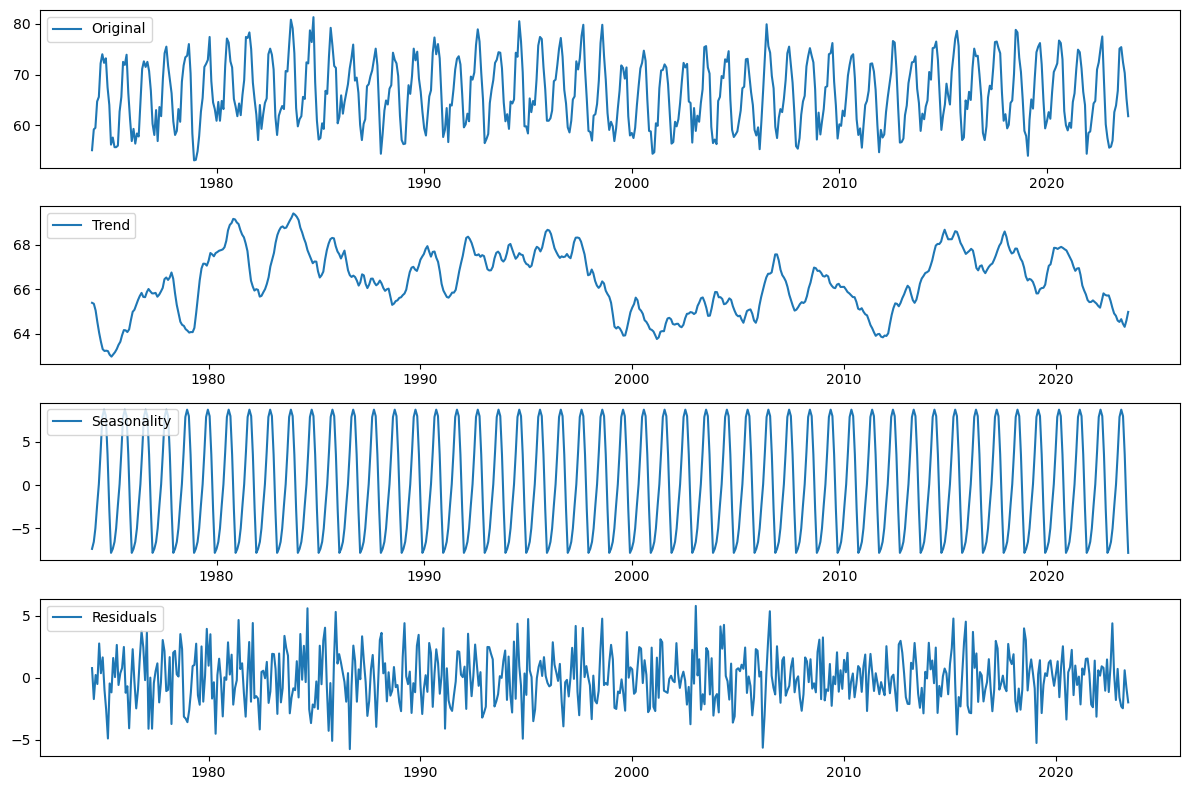

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38221D+00    |proj g|=  1.14491D-01

At iterate    5    f=  2.26819D+00    |proj g|=  2.89568D-02

At iterate   10    f=  2.25502D+00    |proj g|=  4.72850D-03

At iterate   15    f=  2.25453D+00    |proj g|=  4.31610D-04

At iterate   20    f=  2.25452D+00    |proj g|=  7.13696D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     25      1     0     0   7.137D-06   2.255D+00
  F =   2.2545222463221655     

CONVERG

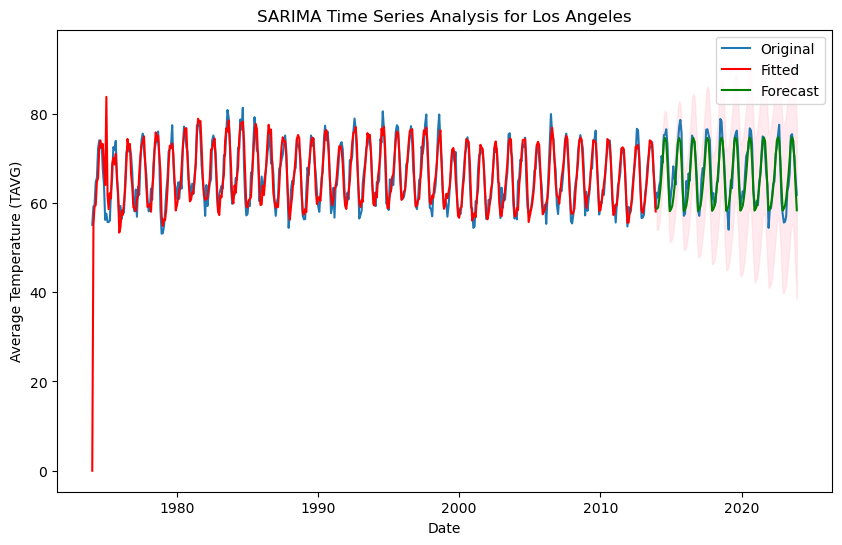

SARIMA Model Summary for Los Angeles


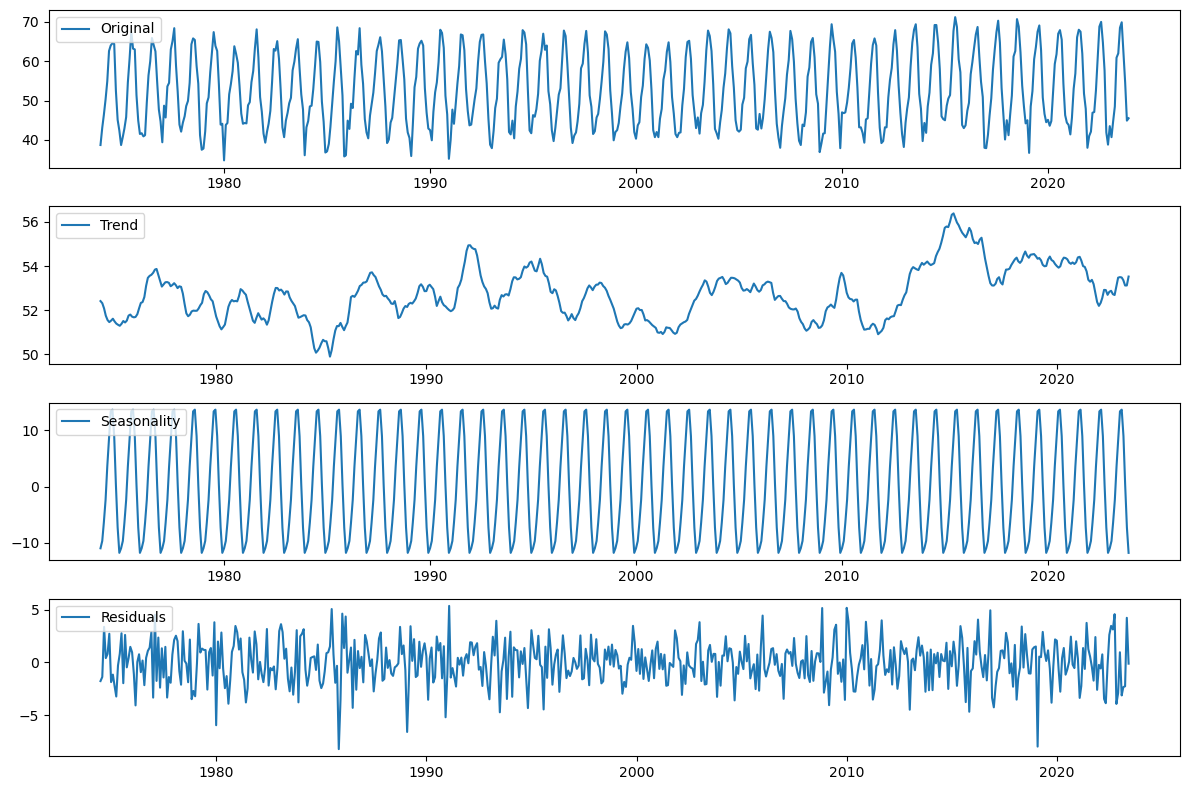

/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/rileychisholm/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35872D+00    |proj g|=  9.98890D-02

At iterate    5    f=  2.23390D+00    |proj g|=  2.58806D-02

At iterate   10    f=  2.21951D+00    |proj g|=  9.19680D-03

At iterate   15    f=  2.21870D+00    |proj g|=  1.05357D-02

At iterate   20    f=  2.21857D+00    |proj g|=  1.36313D-03

At iterate   25    f=  2.21856D+00    |proj g|=  1.06425D-04

At iterate   30    f=  2.21856D+00    |proj g|=  5.73103D-05

At iterate   35    f=  2.21856D+00    |proj g|=  1.07068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

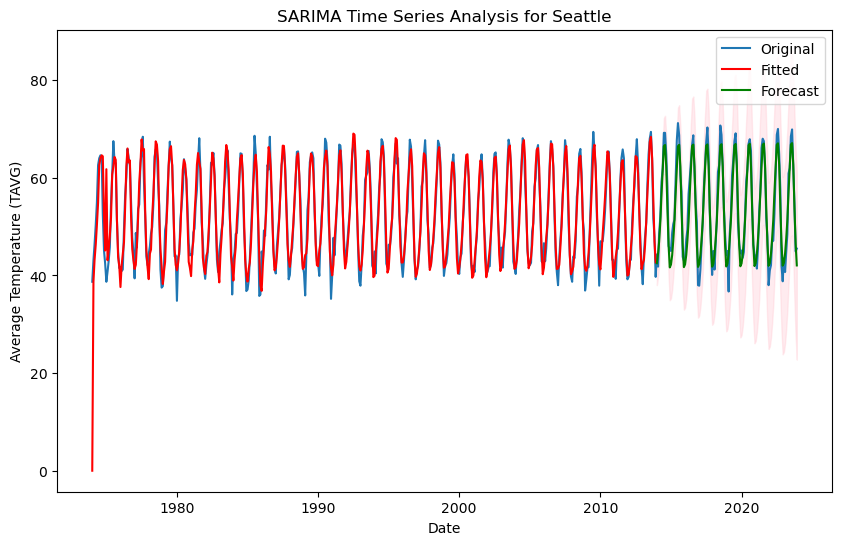

SARIMA Model Summary for Seattle


In [37]:
# Performs SARIMA analysis for each city
for city in cities:
    sarima_city(city)

### Conclusion and Interpretation
In this weather analysis, we explored the trends in average temperatures across several major U.S. cities. Overall, the combination of linear regression and SARIMA analyses suggests that while population growth can be a factor in rising urban temperatures, it is not the sole determinant. The effectiveness of local policies, environmental regulations, and city-specific factors play crucial roles in shaping the climate outcomes of urbanization. As cities continue to grow, understanding and addressing these additional factors will be key to managing urban climates effectively.